# Taller Computacional 1: Sistemas reaccionantes homogéneos con múltiples reacciones en paralelo y/o serie

La clave de estos sistemas es la simulación de procesos dinámicos, es decir, que ocurre una evolución en el tiempo de estos componentes. 
Usualmente, cuando una variable depende del tiempo se utilizan modelos basados en ecuaciones diferenciales ordinarias para poder estudiar el comportamiento del mismo. En caso de que también se quiera estudiar la dependencia espacial, ecuaciones diferenciales parciales son usadas. 

En este introducción, se hará una introducción pequeña a como ver estos sistemas desde el punto de vista computacional, con el proposito de poder simular sistemas reaccionantes homogéneos.

## Sistemas dinámicos

Típicamente, cuando tratamos con sistemas dinámicos (evolucionan en el tiempo) estos se modelan mediante la siguiente expresión

$$
\frac{d\mathbf{x}}{dt} = f(\mathbf{x})
$$

Es decir, se modela por medio de una ecuación diferencial arbitraria donde solo existe una dependencia del tiempo. Notar que en este caso $\mathbf{x}$ es un vector en $\mathbb{R}^n$. Estas ecuaciones diferenciales están acopladas, es decir, la dinámica de $x_1$ depende de la dinámica de $x_2$. Por ejemplo:
$$
\frac{d{x_1}}{dt} = a x_1 + b x_2\\
\frac{d{x_1}}{dt} = c x_1 + d x_2\\
$$

Por lo cuál, este marco también permite estudiar interacciones entre componentes. 

Algunas de estas EDO poseen soluciones analíticas, por ejemplo:

$$
\frac{d{x}}{dt} = x + y\\
\frac{d{xy}}{dt} = x - y\\
$$

Cuya solución viene dada por:
$$
\begin{bmatrix}x(t)\\y(t) \end{bmatrix} = C_1 e^{\sqrt{2}t} \begin{bmatrix}1\\ \sqrt{2} -1 \end{bmatrix} +  C_2 e^{ - \sqrt{2}t} \begin{bmatrix}1\\ -\sqrt{2} -1 \end{bmatrix}
$$

Pero en caso de que exista algún término no-lineal en la ecuación principal. La solución de este sistema, de forma analítica, se hace complicada y en algunos casos imposible.

Por esta razón exiten menras de poder resolver estos sistemas de ecuaciones de forma numérica.

## Resolución numérica de sistemas dinámicos

Tomemos de ejemplo el siguiente sistema dinámico:

$$
\frac{d x}{dt } = \alpha x  - \beta xy \\
\frac{d y}{dt} = -\gamma y + \delta xy
$$

Este es conocido como el modelo Lokta-Volterra. Este es altamente estudiado en áreas como Dinámicas no lineales y Teoría del Chaos (El libro Nonlinear Dynamics and Chaos de Steven Strogatz es una muy buena introducción para los que les interesa). Es importante en este caso, entender las capacidades y limitaciones de `python` para poder simular estos sistemas, de las diferentes herramientas disponibles `solve_ivp` de `scipy` es la más sencilla. Para hacer esto, es necesario describir una función con la siguiente forma:
```python
def dXdt(t, x, params):
	return f(x , params)
``` 
Notar que params puede ser tanto un vector como diferentes entradas de la función. Lo importante es ser consistente con `solve_ivp`.

En esta caso, generamos una función que va a tomar la forma de nuestro sistema de ecuaciones diferenciales. En el caso del sistema antes descrito se realiza de la siguiente forma:

In [ ]:
# primero importamos las librerías necesarias
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [ ]:
def dXdt(t, # tiempo que se utiliza de forma interna en solve_ivp
         X, # vector de inputs
         alpha, beta, gamma, delta # parametros del modelo
         ):
    '''
    La función dXdt define la ecuación diferencial 
    frac{d x}{dt } = alpha x  - beta xy 
	frac{d y}{dt} = -gamma y + delta xy
    '''
    X1, X2 = X # notar que la funcion recibe X como un vector
    dx_dt = alpha * X1 - beta * X1 * X2 
    dy_dt = -gamma * X2 + delta * X1 * X2
    return [dx_dt, dy_dt] # retornamos un vector con las dos ecuaciones diferenciales

Es importante notar que en este caso, como se trata de un **sistema** de ecuaciones diferenciales, los _inputs_ de dXdt son vectores y en consecuencia, lo que se retorna también es un vector que contienen ahora `dx_dt, dy_dt`.
Para poder entender la noción de este proceso, pensemos en una ecuación diferencial del tipo
$$
\frac{dx}{dt} = f(x)
$$
Considerando $dt = \Delta t$ podemos discretizar esta expresión y llegar a:
$$
\frac{\Delta X}{\Delta t} = \frac{X_{t+1} - X_{t}}{\Delta t} = f(x)
$$
De esta forma:
$$
X_{t+1} = \Delta t f(x) + X_t
$$

Entonces, la función `dXdt` que definimos previamente va a llevar la información que le permite a `solve_ivp` realizar el proceso descrito previamente (En la práctica existen métodos más robustos numéricamente, por ejemplo [RK45](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) o [LSODA](https://computing.llnl.gov/projects/odepack)). 

Ahora llevemos a la practica esta noción usando una implementación con `solve_ivp` y una implementación naïve de la metodología previamente descrita (conocida como diferencias finítas).

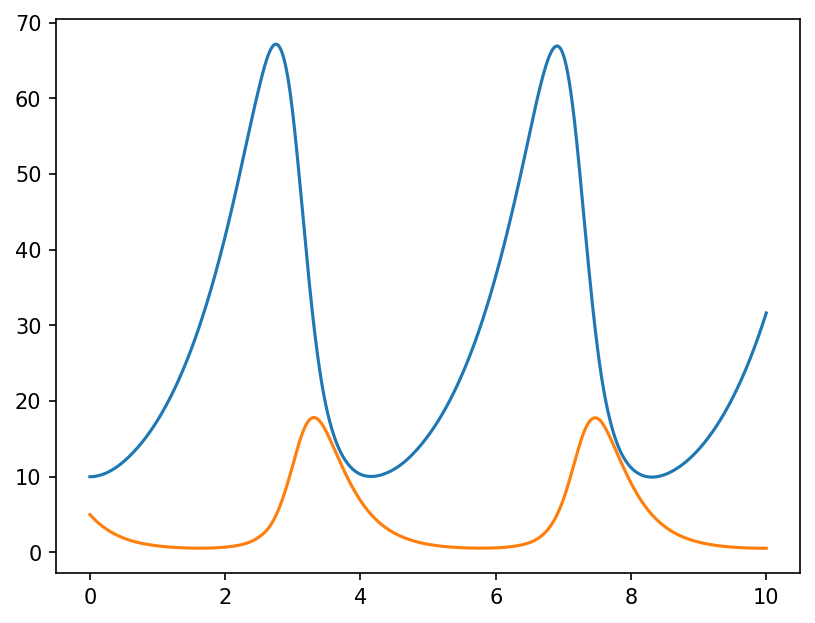

In [ ]:
x0 = [10, 5] # condiciones iniciales
t_span = (0, 10) # intervalo de tiempo
t_eval = np.linspace(t_span[0], t_span[1], 1000) # puntos en los que se evalúa la solución
params = (1, 0.2, 3, 0.1) # parámetros del modelo
sol = solve_ivp(dXdt, # función que define la EDO
                t_span, # tiempo de evaluación
                x0, # condicion incial
                args=params, # parametros de la función , en este caso alpha, beta, gamma y delta SER CONSISTENTE CON EL ORDEN DE LOS PARAMETROS
                t_eval=t_eval, # tiempo en el cuál extraer valores
                method = 'RK45' # método de integración
                ) # resolvemos la ODE

# notar que sol.y contiene las soluciones en los tiempos
plt.figure(dpi = 150)
plt.plot(sol.t, sol.y[0], label='X1 (presa)')
plt.plot(sol.t, sol.y[1], label='X2 (depredador)')

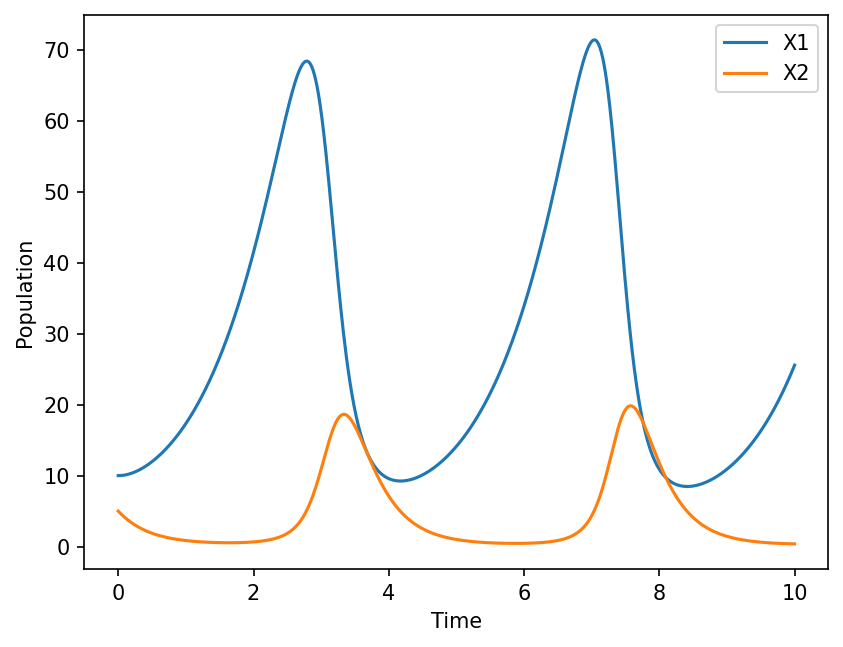

In [55]:
# definamos ahora diferencias finitas para comparar
def dif_fin_lv(X_t, alpha, beta, gamma, delta, dt=0.01):
	X1, X2 = X_t
	# notar que de aquí para abajo es lo mismo que dXdt solo que modificado para que funcione en este caso
	dx_dt = alpha * X1 - beta * X1 * X2 
	dy_dt = -gamma * X2 + delta * X1 * X2
	X1_t1 = X1 + dx_dt * dt
	X2_t1 = X2 + dy_dt * dt
	return [X1_t1, X2_t1]

x0 = [10, 5] # condiciones iniciales
t_final = 10
dt = 0.01 # noten que el solver es sensible a este valor pruebenlo 
n_steps = int(t_final / dt)
params = (1, 0.2, 3, 0.1) # parámetros del modelo vienen de antes
X = []
X.append(x0)
for i in range(n_steps):
	X_new = dif_fin_lv(X[-1], *params, dt=dt)
	X.append(X_new)

X = np.array(X)
t = np.linspace(0, t_final, n_steps + 1)
plt.figure(dpi = 150)
plt.plot(t, X[:, 0], label='X1')
plt.plot(t, X[:, 1], label='X2')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()

Con esto podemos ver que se ambas metodologías llegan a soluciones similares. En particular, es posible demostrar que diferencias finítas no es tan estable como otras metodologías disponibles al usar `solve_ivp`, pero al menos queda la intuición de que es lo que está pasando por detrás de estos procesos.

A partir de este proceso, es posible generar la siguiente receta para poder resolver un problema que puede ser modelado mediante una ODE:
1. Definir las variables. Por ejemplo, x e y.
2. Identificar la función que define el sistema de EDOs. Es decir identificar la $f(x)$ que está en $dx/dt = f(x)$. Es importante llegar a que el diferencial esté de un lado y la función del otro.
3. Poner la EDO en una función del estilo `def f(t, x, params)`. 
4. Resolver con `solve_ivp`.
5. Realizar análisis posteriores.


## Estimación de parámetros

Muchas veces, es necesario estimar parámetros a partir de uno o más datos experimentales. Por ejemplo, digamos que podemos modelar un experimento mediante la siguiente relación lineal:
$$
z = a \cdot x_0 + b \cdot y_0
w = a \cdot x_0 - b \cdot y_0
$$
Donde $x_0,y_0$ son variles iniciales que se saben desde un inicio (por ejemplo concentraciones iniciales), $z, w$ son variables medidas, y $a,b$ son parámetros que se quieren estimar. Si se quieren estimar los valore de $a,b$ a partir de mediciones $z_1$ y $w_1$ es posible realizarlo por medio del siguiente problema de optimización.
$$
a, b = \argmin_{a,b} (z(a,b, x_0, y_0) - z_1)^2 + (w(a,b, x_0, y_0) - w_1)^2
$$

Puesto en palabras significa: "Estamos buscando los valores de $a$ y $b$ que minimizan la diferencia cuadrática entre los valores de $z(a,b)$ y $w(a,b)$ con las mediciones $z_1$ y $w_1$, sabiendo tambión $x_0$ y $y_0$". En este caso, $z$ y $w$ son funciones de (a,b). Este tipo de problemas pueden ser planteados de la siguiente forma:

In [66]:
#1. planteas variables que se conocen (notar que no necesariamente significan algo)
x0 = 1
y0 = 0.5
z = 3
w = 2

#2. definir el problema de optimizacion

def min_cuad(var, x0, y0, z1, w1):
    a,b = var
    z = a * x0 + b * y0
    w = a * x0 - b * y0
    return (z - z1)**2 + (w - w1)**2

La sintaxis del problema que se debe generar debe seguir la siguiente forma para ser compatible con el optimizador a utilizar: `scipy.optimize.minimize`.
```python
def obj(x, *args):
	return objective_funct
```
En este caso, x puede ser un vector o un valor en particular. En el caso anterior, `var = [a,b]`, por lo cuál podemos extraer las variables después para trabajar con ellas. Luego `*args` son los parámetros de la función, en este caso son los valores conocidos `x0, y0, z1, w1`. Al igual que con `solve_ivp`,  hay que tener presente el orden de las variables. Luego, para encontrar los valores de $a$ y $b$, se utiliza `minimize` de la siguiente forma:

In [67]:
from scipy.optimize import minimize

In [ ]:
res = minimize(min_cuad, # función a minimizar,
               x0 = [0.1, 0.1], # valor inicial de las variables a optimizar
               args = (x0, y0, z, w), # parámetros adicionales de la función RECUERDEN EL ORDEN
				method = 'Nelder-Mead' # método de optimización
    )

array([2.5000106 , 0.99997304])

De esta forma, obtenemos los resultados al analizar el objeto `res`. En particular, los valores óptimos de $a$ y $b$ se encuentran en `res.x`.

Así, para poder resolver un poblema de estimación de parámetros, la receta es la siguiente:
1. Definir las variables conocidas y las mediciones.
2. Definir la función que describe el sistema (en este caso, las ecuaciones que relacionan las variables conocidas y los parámetros a estimar con las mediciones).
3. Definir la función objetivo que se quiere minimizar.
4. Utilizar `minimize` para encontrar los parámetros óptimos.

Para otros casos puede ser más complejo, pero el procedimiento es similar.